In [2]:
### IMPORTS ###
import numpy as np
import matplotlib.pyplot as plt
import time

# Divide the code to individual files and import here.

In [3]:
### GENERAL UTILS ###

def matmul(A, B):
    n = A.shape[0]
    res = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                res[i][j] += A[i][k] * B[k][j]
    return res

def matvecmul(A, b):
    C = []
    for row in A:
        rowsum = 0
        for j, val in enumerate(row):
            rowsum += val * b[j]
        C.append(rowsum)
    return np.array(C)

def dot(a, b):
    sum = 0
    for i, val in enumerate(a):
        sum += val * b[i]
    return sum

def norm(v): # L2-Norm of a Vector
    sum = 0
    for val in v:
        sum += val*val
    return np.sqrt(sum)

def matrixnorm(A, x):
    return np.sqrt(dot(matvecmul(A, x), x))

In [4]:
### WORK PACKAGE 1 UTILS ###

def read_msr(filepath = "gmres_test_msr.txt"):
    msr_file = open(filepath, 'r')
    lines = msr_file.readlines()
    msr_file.close()
    flag = lines[0].strip()
    dim, size = lines[1].strip().split()
    dim = int(dim)
    size = int(size)

    JM = np.zeros(size)
    VM = np.zeros(size)
    for i,line in enumerate(lines[2:]):
        JM[i] = line.split()[0]
        VM[i] = line.split()[1]
    JM = JM.astype(int) - 1
    return (JM, VM, dim)

def msrmul(JM, VM, x, symmetric = False): # A * x, where A is a matrix in MSR format, and x is a vector.
    dim = x.size
    y = matvecmul(np.diag(VM[0:dim]), x)
    if (symmetric):
        # y = Dx + Ux + Lx for symmetrical MSR
        for i in np.arange(dim):
            i1 = JM[i]
            i2 = JM[i+1]
            if (i1 == i2): continue
            y[i] +=  dot(VM[i1:i2], x[JM[i1:i2]])
            y[JM[i1:i2]] += VM[i1:i2] * x[i]
    else:
        # y = Ax for non-symmetrical MSR
        for i in np.arange(dim):
            i1 = JM[i]
            i2 = JM[i+1]
            if (i1 == i2): continue
            y[i] += dot(VM[i1:i2], x[JM[i1:i2]])
    return y

def to_msr(A, symmetric = False): # Encodes matrix A into MSR format.
    VM = [A[i,i] for i in np.arange(A.shape[0])]
    VM.append(0)
    IM = [A.shape[0] + 1]
    JM = []
    for i, row in enumerate(A):
        found_values = 0
        for j, val in enumerate(row):
            if (i != j):
                if (val != 0):
                    found_values += 1
                    VM.append(val)
                    JM.append(j)
        IM.append(IM[-1] + found_values)
    if (symmetric):
        repeat_ind = int(len(JM)/2) 
        JM = JM[:repeat_ind]
        VM = VM[:-repeat_ind]
    IM.extend(JM)
    return np.array(IM), np.array(VM) # IM: Index Matrix, as JM finally.

def msrnorm(JM, VM, x, symmetric = False): # A norm of vector x in MSR format.
    return np.sqrt(dot(msrmul(JM, VM, x, symmetric), x))

In [5]:
### WORK PACKAGE 2 UTILS ###

precond_dict = {
    0: "No preconditioning",
    1: "Jacobian preconditioning",
    2: "Gauss-Seidel preconditioning",
    3: "ILU(0) preconditioning",
}

def back_sub(U, y): # Solves vector x for linear system Ux = y. Where U is an upper triangular matrix.
    n = U.shape[0]
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        sub = y[i]
        for j in range(i+1, n):
            sub -= U[i,j] * x[j]
        x[i] = sub / U[i,i]
    return x

def forth_sub_inv(L): # Inverts lower triangular matrix.
    n = L.shape[0]
    L_inv = np.zeros((n,n))
    I = np.eye(n)
    for i in range(n):
        for j in range(i+1):
             L_inv[i,j] = (I[i,j] - dot(L[i,:i], L_inv[:i,j])) / L[i,i]
    return L_inv

def back_sub_inv(U): # Inverts upper triangular matrix.
    n = U.shape[0] 
    U_inv = np.zeros((n,n)) 
    I = np.eye(n) 
    for i in range(n-1, -1, -1):
        for j in range(n-1, i-1, -1):
            U_inv[i,j] = (I[i,j] - dot(U[i,i:], U_inv[i:,j])) / U[i,i]
    return U_inv

def ILU0(A): # Performs ILU0 decomposition on matrix A.
    n = A.shape[0]
    L = np.zeros_like(A)
    U = np.zeros_like(A)
    for k in range(n):
        L[k, k] = 1
        for j in range(k+1, n):
            L[j, k] = A[j, k] / A[k, k]
            for i in range(k+1, n):
                A[j, i] -= L[j, k] * A[k, i]
        for i in range(k, n):
            U[k, i] = A[k, i]
    return L, U

def getGivens(upper, lower): # Returns cos and sin values of a right triangle.
    hypo = np.sqrt(upper*upper + lower*lower)
    return (upper/hypo, lower/hypo)

def getKrylov(JM, VM, precond, P, V, H, j):
    if (precond == 0):
        w = msrmul(JM, VM, V[:,j])
    else:
        PJM, PVM = P
        w = msrmul(PJM, PVM, msrmul(JM, VM, V[:,j]))

    for i in range(j+1):
        H[i,j] = dot(V[:,i],w)
        w = w - H[i,j] * V[:,i]        
    H[j+1,j] = norm(w)
    V[:,j+1] = w / (H[j+1,j])
    

In [6]:
### FULL GMRES ALGORITHM ###

def fullGMRES(JM, VM, x0, b, precond, P, m=100, tol=1e-08):
    n = len(b)
    H = np.zeros((m+1,m)) # Complete Hessenberg is created here, because appending vectors to a matrix is much slower than having the entire matrix prepared as a placeholder firsthand.
    V = np.zeros((n,m+1)) # Also for V. I chose this method because the program never exceeded 1 GB of ram.
    e1 = np.zeros(m+1)
    e1[0] = 1
    
    if (precond == 0):
        r0 = (b - msrmul(JM, VM, x0))
    else:
        PJM, PVM = P
        r0 = msrmul(PJM, PVM, b - msrmul(JM, VM, x0))
 
    beta = norm(r0)
    V[:,0] = r0 / beta
    g = beta*e1
    c = np.zeros(m)
    s = np.zeros(m)
    ros = np.zeros(m)

    for j in range(m):
        getKrylov(JM, VM, precond, P, V, H, j)
        for k in range(j):
            k += 1
            temp = c[k-1]*H[k-1,j] + s[k-1]*H[k,j]
            H[k,j] = -s[k-1]*H[k-1,j] + c[k-1]*H[k,j]
            H[k-1,j] = temp
        c[j], s[j] = getGivens(H[j,j], H[j+1,j])
        H[j,j] = c[j] * H[j,j] + s[j] * H[j+1,j]
        g[j+1] = -s[j]*g[j]
        g[j] = c[j]*g[j]
        rel_ro = np.abs(g[j+1]) / beta
        ros[j] = rel_ro
        print("[@ Krylov-Space:",j+1,"] Error =", np.abs(g[j+1]), "Relative residual =", rel_ro)
        if rel_ro <= tol: 
            print("Converged at inner iteration:", j+1, "(A dimension:", n,")")
            break
        
    m_hat = min(m,j+1)
    m = m_hat
    Rm = [H[i,j] if i <= j else 0 for i in range(m) for j in range(m)]
    Rm = np.reshape(Rm, (m,m))
    y_star = back_sub(Rm, g[:m])
    xm = x0 + matvecmul(V[:,:m], y_star)
    return (xm, np.abs(g[j+1]), ros[:m], V[:,:m])


In [7]:
### RESTARTED GMRES ###
### !!! WARNING: Construction of GS and ILU0 preconditioners are not in msr format, hence can take some time. (~5mins, ~20mins)

def GMRES(JM, VM, x0, b, precond = 0, m=100, tol=1e-08, maxit=600):
    """
    Restarted GMRES Algorithm.

    :param JM: Column/index vector of MSR.
    :param VM: Value vector of MSR.
    :param x0: Initial guess.
    :param b: Target/result.
    :param precond: Preconditioner method. Available int args: {0:No preconditioning(default), 1: Jacobian, 2: Gauss-Seidel, 3: ILU0}.
    :param m: Krylov-Space dimensions.
    :param tol: Tolerance of acceptable convergence.
    :param maxit: Maximum amount of iterations without convergence.
    :return: Returns converged solution, absolute error, relative error, execution time, and V matrix of Krylov Space.
    """
    dim = len(x0)
    
    print(precond_dict[precond], "selected.")
    if (precond == 1): # Jacobi preconditioner. Diagonal of the model matrix.
        P = np.diag(1/(VM[0:dim]+1e-25)) 
        PJM, PVM = to_msr(P)
        P = (PJM, PVM)
    elif (precond == 2): # Gauss-Seidal preconditioning.
        M = np.zeros((dim,dim))
        I = np.eye(dim)
        for j in range(dim):
            M[:,j] = msrmul(JM, VM, I[:,j])
        P = forth_sub_inv(M) # Inverting M
        PJM, PVM = to_msr(P)
        P = (PJM, PVM)
    elif (precond == 3): # ILU preconditioning.
        M = np.zeros((dim,dim))
        I = np.eye(dim)
        print("Constructing M...")
        for j in range(dim):
            M[:,j] = msrmul(JM, VM, I[:,j])
        print("Decomposing into ILU0...")
        L, U = ILU0(M)
        print("Calculating L inverse...")
        L_inv = forth_sub_inv(L)
        print("Calculating U inverse...")
        U_inv = back_sub_inv(U)
        print("Constructing preconditioner...")
        P = matmul(L_inv, U_inv)
        # np.save("ILU0preconditioner.npy", P)
        # P = np.load("ILU0preconditioner.npy")
        PJM, PVM = to_msr(P)
        P = (PJM, PVM)
    else:
        P = None

    x = x0
    r0 = b - msrmul(JM, VM, x)
    absro = norm(r0)
    i = 0
    start = time.time()
    while absro > tol:
        print("Outer iteration:", i+1, "......")
        xm, absro, ros, V = fullGMRES(JM, VM, x, b, precond, P, m=m, tol=tol)
        x = xm 
        i+=1
        print("[It:",i,"] Absolute error:", absro)
        if i >= maxit: break
    exec_time = time.time() - start
    print("Converged at outer iteration:", i)
    print("Solution:")
    print(x)
    
    return x, absro, ros, exec_time, V

JM, VM, dim = read_msr("gmres_test_msr.txt")
b = msrmul(JM, VM, np.ones(dim), False)
x0 = np.zeros(dim)

# Testing different parameters m for restarted GMRES.
#_, _, erros, exec_time, _ = GMRES(JM, VM, x0, b, 0, 400, 1e-08, 999)
#print(exec_time)

In [7]:
### Full GMRES bench with different preconditioners. ###

errorz = []
times = []
for i in range(4):
    _, _, erros, exec_time, _ = GMRES(JM, VM, x0, b, i, 600, 1e-08, 1)
    errorz.append(erros)
    times.append(exec_time)
    print(precond_dict[i], "took", exec_time, "seconds to complete.")

No preconditioning selected.
Outer iteration: 1 ......
[@ Krylov-Space: 1 ] Error = 490.761343081812 Relative residual = 0.9951217437186914
[@ Krylov-Space: 2 ] Error = 490.63322444186974 Relative residual = 0.9948619562554377
[@ Krylov-Space: 3 ] Error = 490.02806785534204 Relative residual = 0.9936348741184734
[@ Krylov-Space: 4 ] Error = 477.4443908661058 Relative residual = 0.9681188248932311
[@ Krylov-Space: 5 ] Error = 465.25124822567835 Relative residual = 0.9433946661207457
[@ Krylov-Space: 6 ] Error = 445.593317785911 Relative residual = 0.9035340815557936
[@ Krylov-Space: 7 ] Error = 433.04165583892035 Relative residual = 0.8780829495558254
[@ Krylov-Space: 8 ] Error = 425.77363653251666 Relative residual = 0.8633455132285232
[@ Krylov-Space: 9 ] Error = 409.3368361313123 Relative residual = 0.8300164466527234
[@ Krylov-Space: 10 ] Error = 408.629603363947 Relative residual = 0.8285823836104798
[@ Krylov-Space: 11 ] Error = 407.8166123944284 Relative residual = 0.826933873591

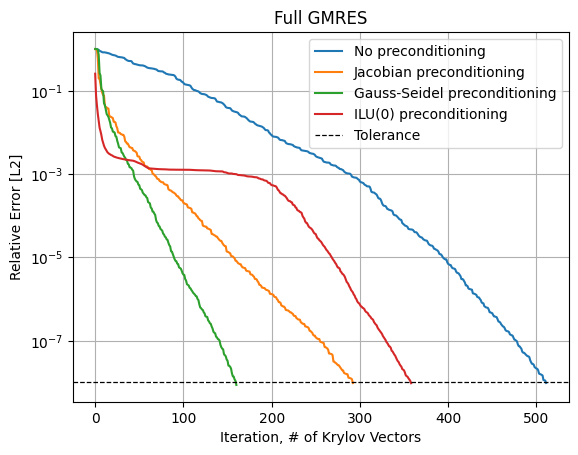

No preconditioning took: 512 Krylov Vectors
Jacobian preconditioning took: 293 Krylov Vectors
Gauss-Seidel preconditioning took: 161 Krylov Vectors
ILU(0) preconditioning took: 359 Krylov Vectors
Execution times respectively:
[224.5627143383026, 213.13137340545654, 117.86377429962158, 374.5501654148102]


In [8]:
### Plotting Bench Results ###

plt.plot(errorz[0],  label = precond_dict[0])
plt.plot(errorz[1],  label = precond_dict[1])
plt.plot(errorz[2],  label = precond_dict[2])
plt.plot(errorz[3],  label = precond_dict[3])
plt.axhline(y = 1e-8, linestyle="dashed", color="k", label = "Tolerance", linewidth=0.9)
plt.legend(loc="upper right")
plt.yscale("log")
plt.xlabel("Iteration, # of Krylov Vectors")
plt.title("Full GMRES")
plt.ylabel("Relative Error [L2]")
plt.grid()
#plt.savefig("FullGMRES.jpeg", dpi=200)
plt.show()
print(precond_dict[0], "took:", len(errorz[0]), "Krylov Vectors")
print(precond_dict[1], "took:", len(errorz[1]), "Krylov Vectors")
print(precond_dict[2], "took:", len(errorz[2]), "Krylov Vectors")
print(precond_dict[3], "took:", len(errorz[3]), "Krylov Vectors")
print("Execution times respectively:")
print(times)

In [ ]:
### Checking For Orthogonality of Krylov Vectors ###

_, _, errors2, exec_time, V = GMRES(JM, VM, x0, b, 0, 600, 1e-08, 1)

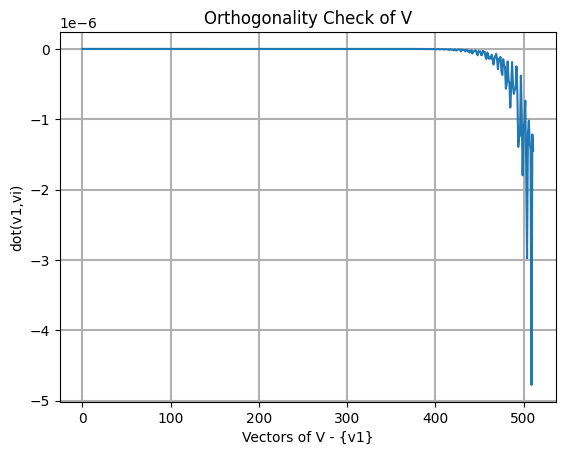

In [10]:
### Plotting Orthogonality Results ###

testarr = np.zeros((V.shape[1]))
for i in range(V.shape[1]-1):
    i += 1
    testarr[i] = dot(V[:,0], V[:,i])
plt.plot(testarr)
plt.title("Orthogonality Check of V")
plt.xlabel("Vectors of V - {v1}")
plt.ylabel("dot(v1,vi)")
plt.grid(lw=1.5)
#plt.savefig("OrthogonalityCheck.jpg", dpi=200)

In [14]:
### THE CG ALGORITHM ###

def CG(JM, VM, x0, b, tol, maxit):
    dim = len(b)
    x = x0.copy()
    r = b - msrmul(JM,VM,x,True)
    p = r.copy()

    ro = norm(r)
    anorm = msrnorm(JM, VM ,(x0-1), True)
    
    errors = np.zeros(maxit)
    anorms = np.zeros(maxit)
    it = 0    
    while ro > tol:
        Ap = msrmul(JM, VM, p, True)
        r_sqr = dot(r, r)
        alfa = r_sqr / dot(Ap,p)
        x = x + alfa * p
        r2 = r - alfa * Ap
        beta = dot(r2,r2) / r_sqr
        p = r2 + beta * p
        r = r2
        e = x - 1 # 1 acts as np.ones(dim)
        ro = norm(r)
        anorm = msrnorm(JM, VM ,e, True)
        errors[it] = ro
        anorms[it] = anorm
        it += 1
        print("[It:", it, "]", "Residual =", ro, "A-Norm =", anorm)
        print("Solution:", x)
        if it >= maxit:
            print("Max iteration reached with no convergence.")
            print("Last solution:")
            print(x)
            return x, errors, anorms
    errors = errors[:(it-1)]
    anorms = anorms[:(it-1)]

    print("Converged in", it, "steps.")
    print("Solution:")
    print(x)
    return x, errors, anorms


In [15]:
### Running CG ###

JM, VM, dim = read_msr("cg_test_msr.txt")
x0 = np.zeros(dim)
b = msrmul(JM, VM, np.ones(dim), True)

start = time.time()
xm, cgerrors, anorms = CG(JM, VM, x0, b, 1e-08, 200)
cgtime = time.time() - start

[It: 1 ] Residual = 5211.73378866098 A-Norm = 211.67810845759203
Solution: [-7.35291462e-02 -1.24075469e-02 -6.54877750e-05 ... -1.03834376e-06
  3.67718774e-04 -7.65598285e-06]
[It: 2 ] Residual = 3898.0116267553717 A-Norm = 176.90343420061305
Solution: [-1.06955818e-01 -2.05918814e-02 -1.09195986e-04 ... -2.49306222e-06
  7.76433006e-04 -1.65917612e-05]
[It: 3 ] Residual = 3253.5230610730705 A-Norm = 154.03844450699427
Solution: [-1.13561893e-01 -2.96350566e-02 -1.59156219e-04 ... -4.67660477e-06
  1.16750357e-03 -2.47287911e-05]
[It: 4 ] Residual = 2788.359433698288 A-Norm = 139.26525215483687
Solution: [-1.03654664e-01 -3.66777999e-02 -1.98753946e-04 ... -7.22852504e-06
  1.42702622e-03 -2.94987920e-05]
[It: 5 ] Residual = 2468.6948645972584 A-Norm = 129.22504604557724
Solution: [-9.04143232e-02 -4.19539216e-02 -2.28561057e-04 ... -9.98692137e-06
  1.58576241e-03 -3.18263045e-05]
[It: 6 ] Residual = 2022.0933810518402 A-Norm = 119.92335533315624
Solution: [-8.17033059e-02 -4.774587

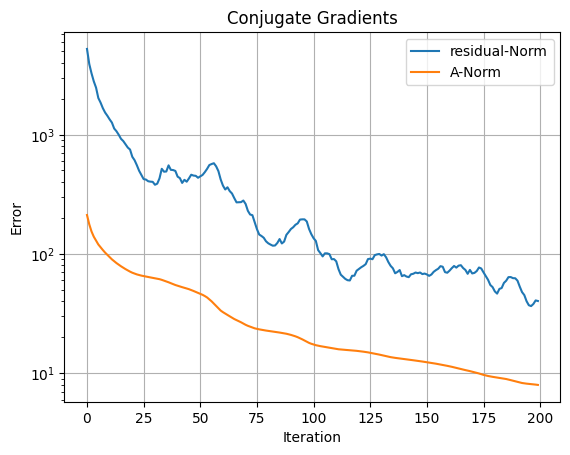

Execution time: 2915.50878739357
Final A-Norm = 7.985425879279881
2915.50878739357


In [16]:
### Plotting for CG ###

plt.plot(cgerrors,  label = "residual-Norm")
plt.plot(anorms,  label = "A-Norm")
plt.legend(loc="upper right")
plt.yscale("log")
plt.title("Conjugate Gradients")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.grid()
#plt.savefig("ConjugateGradients.jpeg", dpi=200)
plt.show()
print("Execution time:", cgtime)
print("Final A-Norm =", anorms[-1])
print(cgtime)
